In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from pathlib import Path
from tensorflow.keras.applications import ResNet50, VGG16, Xception
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
data_dir = "/kaggle/input/pebbles-stones/"
image_dir = Path(data_dir)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
filepaths = pd.Series(filepaths, name = 'Filepath').astype(str)
labels_path = pd.Series(labels, name = 'Label')
labels_df = pd.concat([filepaths, labels_path], axis = 1)

In [5]:
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

In [6]:
datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_dataframe(
    labels_df,
    x_col = "Filepath",
    y_col = "Label",
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

Found 4284 validated image filenames belonging to 2 classes.


In [7]:
def build_and_train_model(base_model_class, model_name):
    base_model = base_model_class(weights = 'imagenet', include_top = False, input_shape = (300, 300, 3))
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    output_layer = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs = base_model.input, outputs = output_layer)
    model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    print(f"Training {model_name}...")
    history = model.fit(train_generator, epochs = 10)
    
    model.save(f"/kaggle/working/{model_name}.h5")
    print(f"Model training complete and saved as /kaggle/working/{model_name}.h5")
    
    return model, max(history.history['accuracy'])

In [8]:
models = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "Xception": Xception
}

trained_models = {}
model_accuracies = {}
for model_name, model_class in models.items():
    trained_models[model_name], model_accuracies[model_name] = build_and_train_model(model_class, model_name)

Training ResNet50...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - accuracy: 0.6464 - loss: 0.6264
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.6473 - loss: 0.6186
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.6705 - loss: 0.6076
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step - accuracy: 0.6709 - loss: 0.6050
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - accuracy: 0.6839 - loss: 0.5917
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.6860 - loss: 0.5888
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.6919 - loss: 0.5906
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6972 - loss: 0.5826
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.6966 - loss: 0.5786
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6980 - loss: 0.5809
Model training complete and saved as /kaggle/working/ResNet50.h5
Training VGG16...
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━

In [9]:
best_model_name = max(model_accuracies, key = model_accuracies.get)
best_model = trained_models[best_model_name]
print(f"Best model selected: {best_model_name} with accuracy {model_accuracies[best_model_name]:.4f}")

Best model selected: Xception with accuracy 0.9255


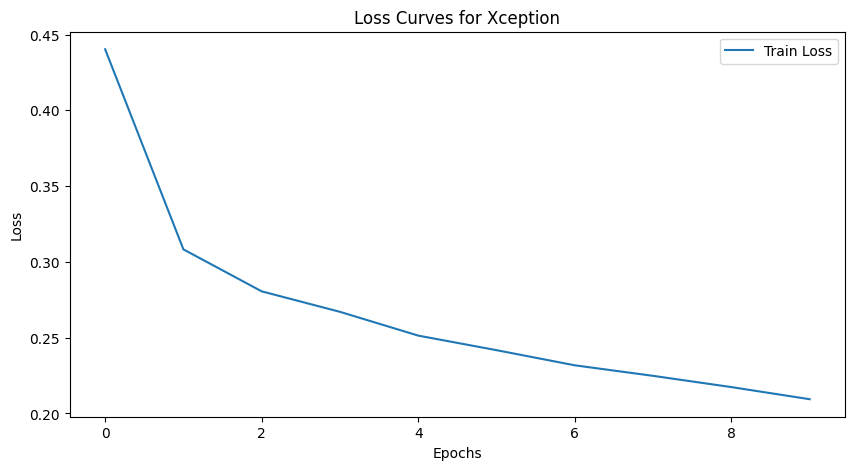

In [10]:
def plot_loss_curves(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label = 'Train Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves for {best_model_name}")
    plt.legend()
    plt.show()

plot_loss_curves(trained_models[best_model_name].history)

In [11]:
test_generator = datagen.flow_from_dataframe(
    labels_df,
    x_col = "Filepath",
    target_size = IMG_SIZE,
    batch_size = 1,
    class_mode = None,
    shuffle = False
)

Found 4284 validated image filenames.


In [12]:
predictions = best_model.predict(test_generator)
labels = (predictions > 0.5).astype(int).flatten()

4284/4284 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step


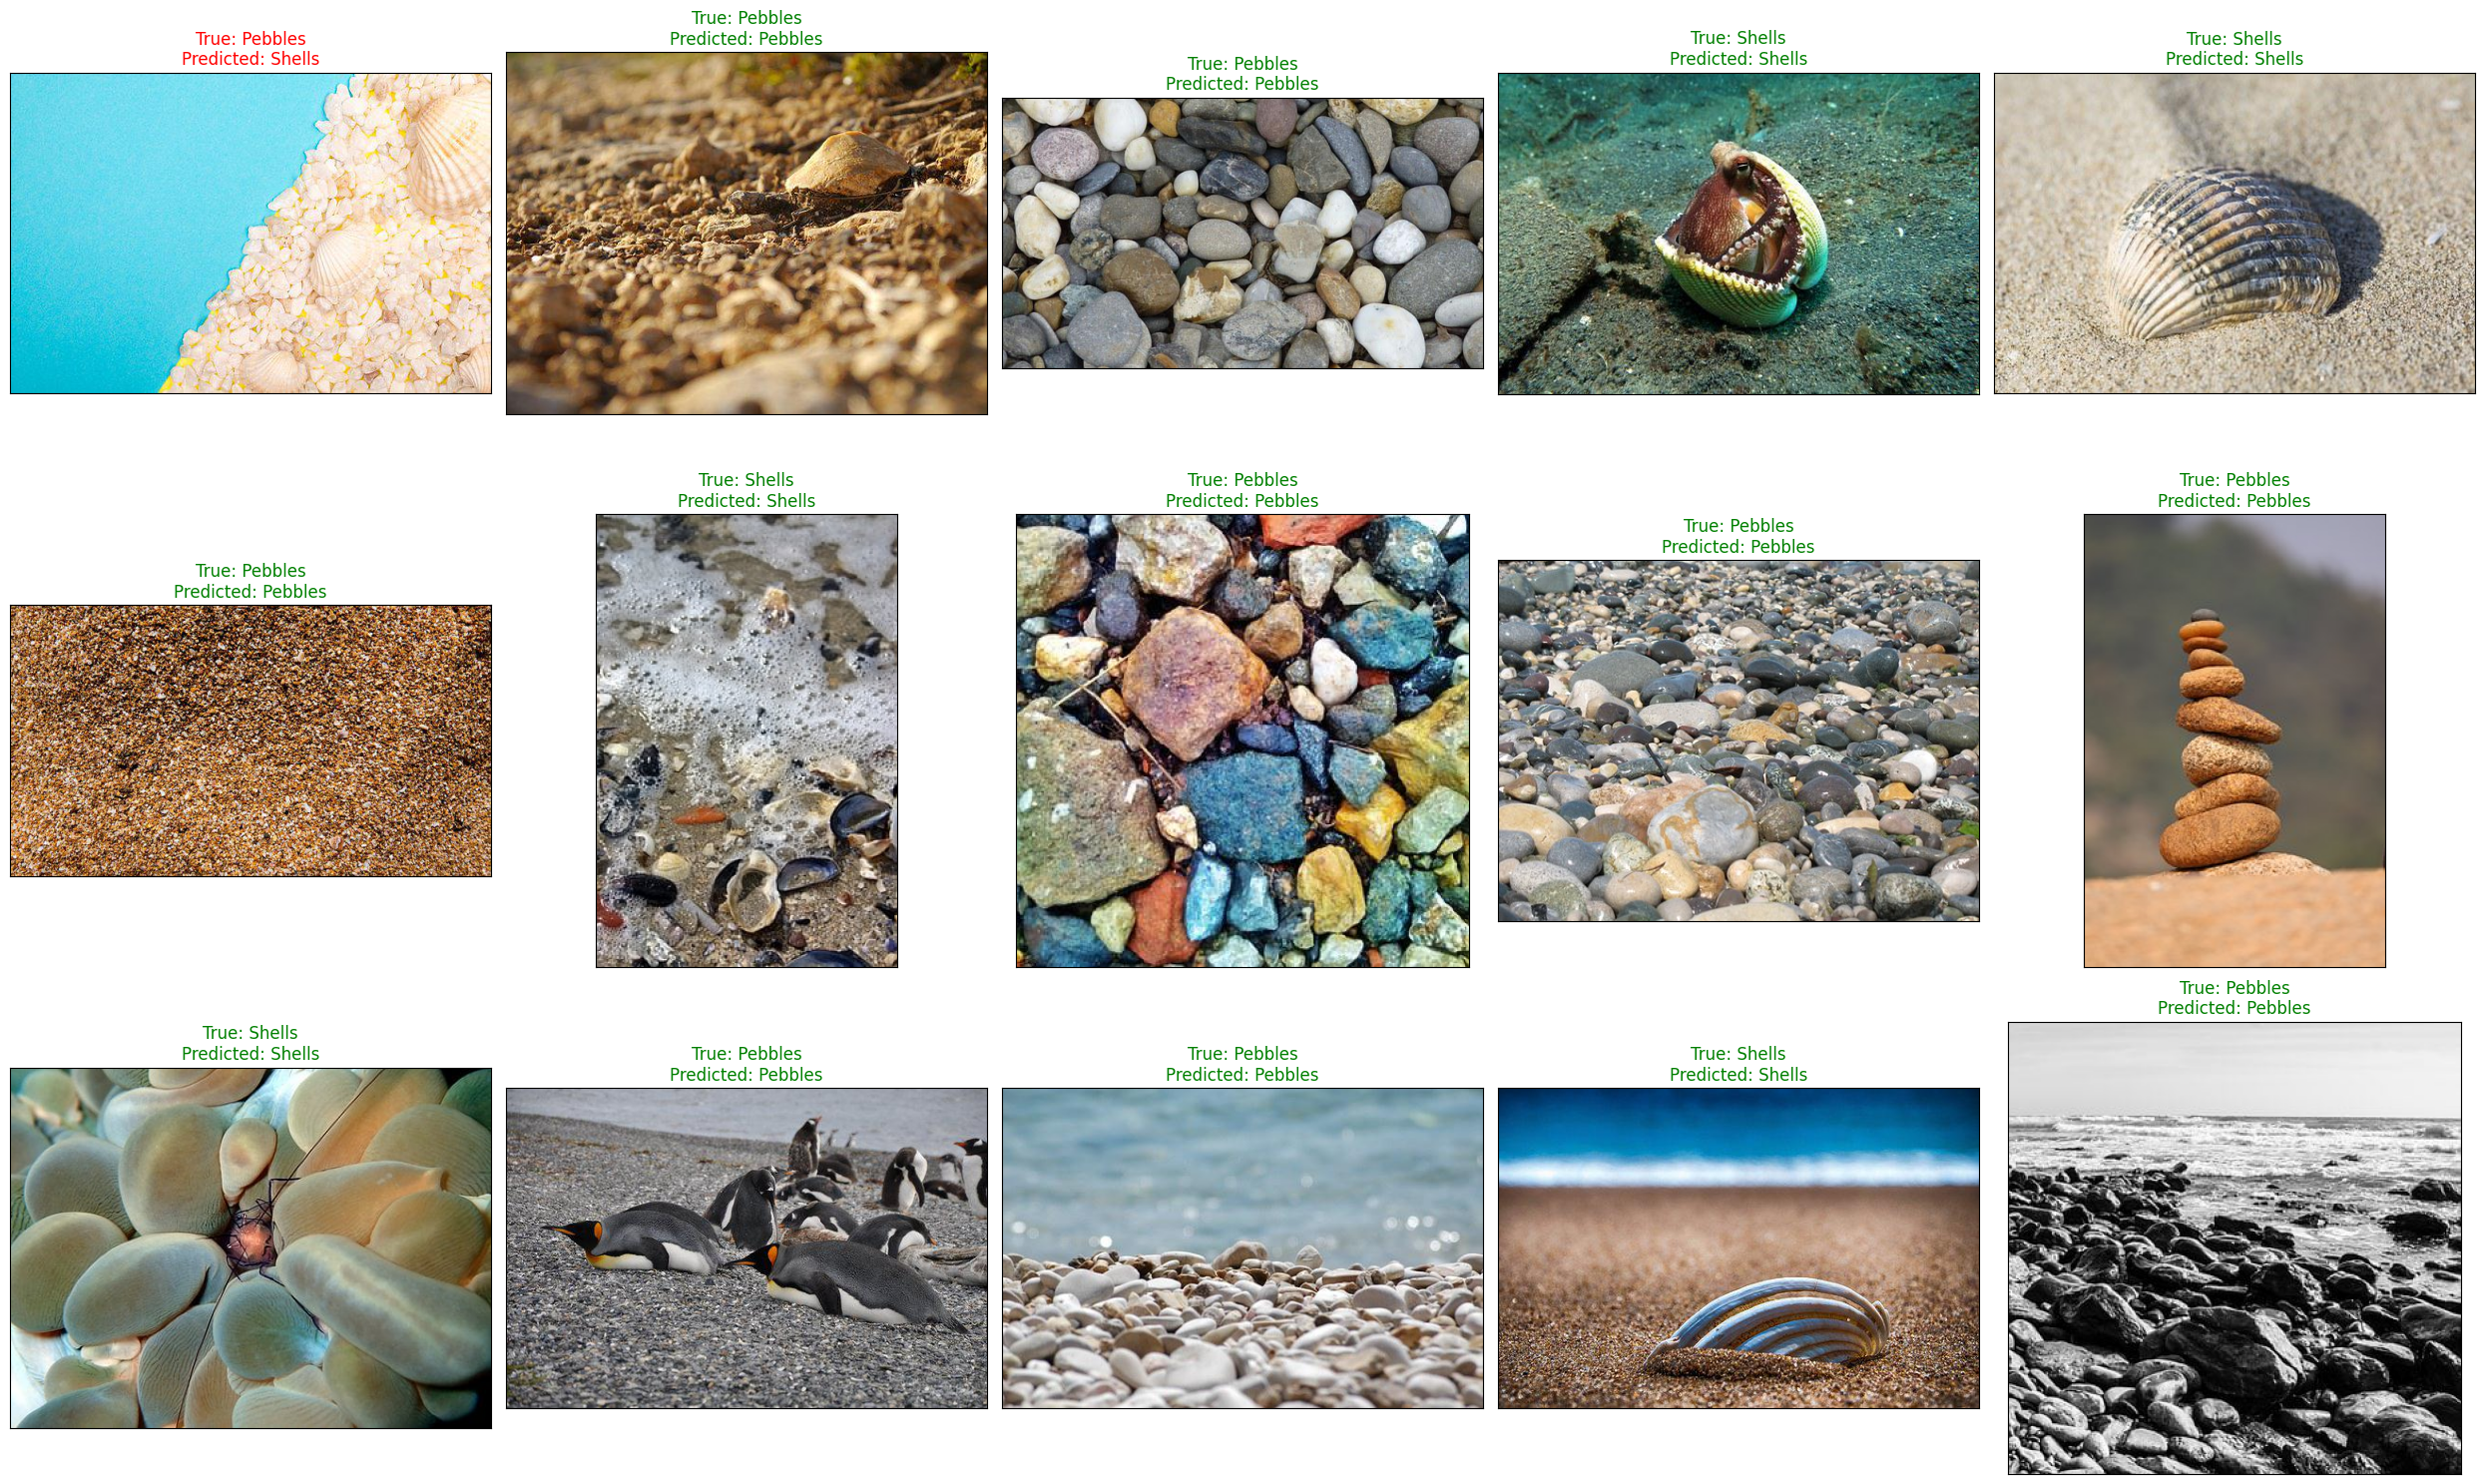

In [20]:
label_mapping = {0: "Pebbles", 1: "Shells"}
predicted_labels = [label_mapping[label] for label in labels]
true_labels = labels_df["Label"].tolist()  

# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(labels_df) - 1, 15)
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (25, 15), subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = labels_df.Filepath.iloc[random_index[i]]
    ax.imshow(plt.imread(img_path))

    true_label = true_labels[random_index[i]]
    pred_label = predicted_labels[random_index[i]]

    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color = color)

plt.tight_layout()
plt.show()

In [14]:
y_test = labels_df["Label"].map({"Pebbles": 0, "Shells": 1}).values
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2743
           1       0.90      0.90      0.90      1541

    accuracy                           0.93      4284
   macro avg       0.92      0.92      0.92      4284
weighted avg       0.93      0.93      0.93      4284



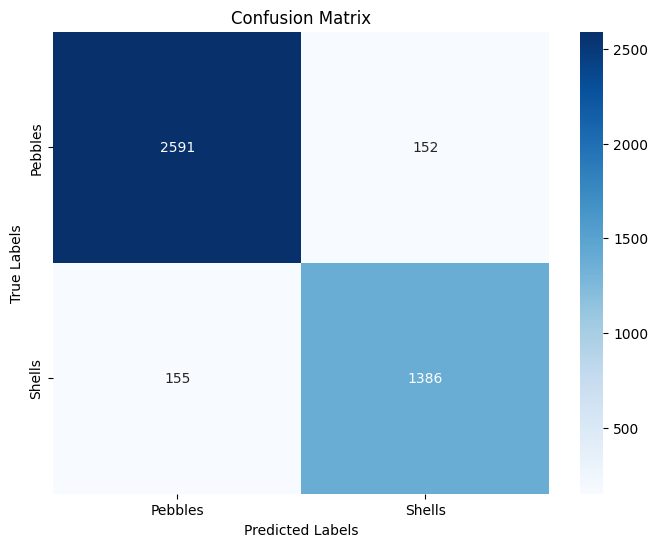

In [15]:
def make_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

make_confusion_matrix(y_test, labels, ["Pebbles", "Shells"])

In [16]:
true_labels = labels_df["Label"].map({"Pebbles": 0, "Shells": 1}).values  
accuracy = accuracy_score(true_labels, labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9283


In [17]:
test_filenames = labels_df["Filepath"].apply(lambda x: os.path.basename(x)).tolist()
submission_df = pd.DataFrame({"id": test_filenames, "filename": test_filenames, "label": labels})
submission_df.to_csv("/kaggle/working/submission.csv", index = False)
print("Submission file saved as /kaggle/working/submission.csv")

Submission file saved as /kaggle/working/submission.csv


In [18]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size = size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis = 0)
    return array


def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layer found in the model")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) if np.max(heatmap) > 0 else 1)
    return heatmap

def save_and_display_gradcam(img_path, heatmap, alpha = 0.4):
    img = cv2.imread(img_path)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))


    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    
    return superimposed_img


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
last_conv_layer_name = get_last_conv_layer_name(best_model)
best_model.layers[-1].activation = None

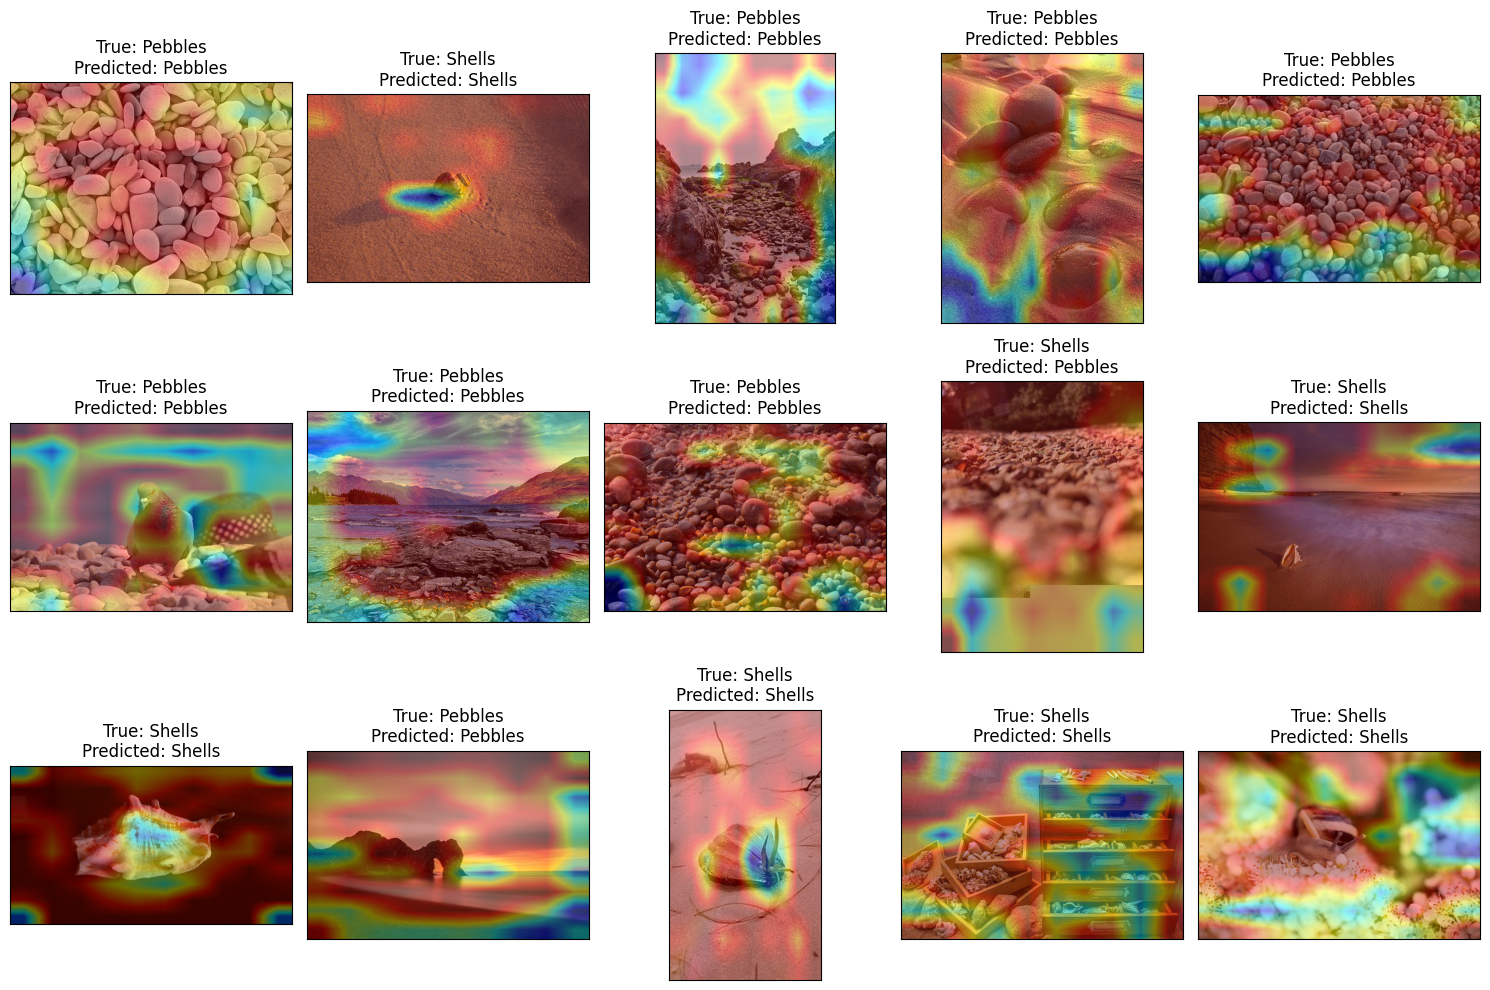

In [19]:
# Select 15 random images for Grad-CAM visualization
random_index = np.random.choice(len(labels_df), 15, replace = False)
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks': [], 'yticks': []})
 
for i, ax in enumerate(axes.flat):
    img_path = labels_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size = (300, 300)))

    heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name)
    gradcam_img = save_and_display_gradcam(img_path, heatmap)

    ax.imshow(gradcam_img)
    ax.set_title(f"True: {labels_df.Label.iloc[random_index[i]]}\nPredicted: {predicted_labels[random_index[i]]}")

plt.tight_layout()
plt.show()